In [1]:
cd ..

/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/code/pipeline_code


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
import numpy as np
import pandas as pd
import json
from collections import defaultdict, Counter
from datetime import datetime as dt

# Regression
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn import gaussian_process
from sklearn.svm import SVR

# Classification
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

/Users/ulfaslak/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [30]:
## General variables
TMPFIGPATH = "visualisation/figures/"
FIGPATH = "../../master_thesis/figures/"

## General dictionaries
with open('globals/feature_name_map.json') as infile:
    feature_name_map = json.load(infile)
with open('globals/super_traits.json') as infile:
    super_traits = json.load(infile)
with open('globals/trait_sign.json') as infile:
    trait_sign = json.load(infile)

## Load data
Xtz = np.loadtxt("data/Xtz.csv", delimiter=",")

Xtz_clean_svm = np.loadtxt("data/Xtz_clean_svm.csv", delimiter=",")
Xtz_clean_kd = np.loadtxt("data/Xtz_clean_kd.csv", delimiter=",")

Xtz_clean_svm_valid_users = np.loadtxt("data/Xtz_clean_svm_valid_users.csv", delimiter=",")
Xtz_clean_kd_valid_users = np.loadtxt("data/Xtz_clean_kd_valid_users.csv", delimiter=",")

Y = np.loadtxt("data/Y.csv", delimiter=",")

Y_clean_kd = np.loadtxt("data/Y_clean_kd.csv", delimiter=",")
Y_clean_svm = np.loadtxt("data/Y_clean_svm.csv", delimiter=",")
M_clean_kd = np.loadtxt("data/M_clean_kd.csv", delimiter=",")
M_clean_svm = np.loadtxt("data/M_clean_svm.csv", delimiter=",")

feat_names = np.load("data/X_2014_%s_feat_names_sorted.pickle" % None)
    
## General functions
def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))
def cp(f):
    return ' '.join([w.capitalize() for w in f.split('_')])
def trytrytry(func):
    """Simple decorator to run functions till they return without error."""
    def wrapper(*args):
        while True:
            try:
                return func(*args)
            except KeyboardInterrupt:
                break
            except:
                pass
    return wrapper

## Regression

In [31]:
N_cv = Y.shape[0] / 10

for i in range(Y.shape[1]):
    score = []
    for fold in range(10):
        test = range(N_cv * fold, N_cv * (fold+1))
        train = list(set(range(Y.shape[0])) - set(test))
        lm = LR().fit(Xtz[train, :], Y[train, i])
        score.append(lm.score(Xtz[test, :], Y[test, i]))
    print np.mean(score)

-0.113990949922
-0.174937299624
-0.102719043365
-0.28504407862
-0.154389254483


#### Conclusion: Regression does not work!

## Supervised learning

In [187]:
def get_classes(Y):
    low_med = sorted(Y)[int(1/3.0*Y.shape[0])]
    high_med = sorted(Y)[int(2/3.0*Y.shape[0])]
    a = []
    for y in Y:
        if y < low_med:
            a.append(0)
        elif y > high_med:
            a.append(2)
        else:
            a.append(1)
    return a

def classifier_score(X, Y):
    N_cv = Y.shape[0] / 10
    score = []
    for fold in range(10):
        test = range(N_cv * fold, N_cv * (fold+1))
        train = list(set(range(Y.shape[0])) - set(test))
        clf = RandomForestClassifier().fit(
            X[train, :], get_classes(Y[train])
        )
        score.append(clf.score(X[test, :], get_classes(Y[test])))
    return np.mean(score)

In [42]:
N_cv = Y.shape[0] / 10
for i in range(Y.shape[1]):
    low_med = sorted(Y[:, i])[int(1/3.0*Y.shape[0])]
    high_med = sorted(Y[:, i])[int(2/3.0*Y.shape[0])]
    score = []
    for fold in range(10):
        test = range(N_cv * fold, N_cv * (fold+1))
        train = list(set(range(Y.shape[0])) - set(test))
        clf = RandomForestClassifier().fit(Xtz[train, :], get_classes(Y[train, i]))
        score.append(clf.score(Xtz[test, :], get_classes(Y[test, i])))
    print np.mean(score)

0.31
0.326666666667
0.366666666667
0.336666666667
0.386666666667


In [196]:
def backwards_forwards_feature_selection(X, Y, scoring_function):
    N, M = X.shape
    removed_counter = Counter()
    recently_removed = [-1] * 2
    fs = np.empty((0, M))
    fs_score = []
    selected_against = set()
    while True:
        fs_iter = [np.nan] * M
        full_score = scoring_function(Xtz[:, list(set(range(M)) - selected_against)], Y)

        start = dt.now()
        remove_candidate = (-1, -0.2)
        for i in set(range(M)) - selected_against:
            iter_score = scoring_function(Xtz[:, list(set(range(M)) - selected_against - {i})], Y)
            i_score = iter_score - full_score
            fs_iter[range(M).index(i)] = i_score
            remove_candidate = (i, i_score) if i_score > remove_candidate[1] else remove_candidate
        #print "remove-loop", dt.now() - start

        recently_removed = recently_removed[1:] + [remove_candidate[0]]

        new_full_score = scoring_function(Xtz[:, list(set(range(M)) - selected_against - {remove_candidate[0]})], Y)

        start = dt.now()
        add_candidate = (-1, 0)
        for i in selected_against - set(recently_removed):
            iter_score = scoring_function(Xtz[:, list((set(range(M)) - selected_against) | {i})], Y)
            i_score = iter_score - new_full_score
            add_candidate = (i, i_score) if i_score > add_candidate[1] else add_candidate
        #print "add-loop", dt.now() - start

        if add_candidate[0] != -1 and removed_counter[add_candidate[0]] < 3:
            fs_iter[range(M).index(add_candidate[0])] = add_candidate[1]
            selected_against.remove(add_candidate[0])
            #print remove_candidate, add_candidate

        if remove_candidate[0] != -1:
            fs = np.vstack([fs, np.array(fs_iter)])
            selected_against.add(remove_candidate[0])
            removed_counter.update([remove_candidate[0]])

        if add_candidate[0] != -1 or remove_candidate[0] != -1:
            start = dt.now()
            score = scoring_function(Xtz[:, list(set(range(M)) - selected_against)], Y)
            fs_score.append(score)
            #print "update-clause", dt.now() - start

        #print recently_removed

        else:
            break

        if len(set(range(M)) - selected_against) < 10:
            break

    plt.figure(figsize=tuple(np.array(fs.shape[::-1]) * 17.0 / fs.shape[1]))
    #plt.title("target %d" % target, fontsize=40)
    sns.heatmap(-fs.T)
    plt.show()
    fig = plt.figure(figsize=(12.25,1))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.tick_right()
    plt.plot(range(len(fs_score)), fs_score)
    #plt.savefig(TMPFIGPATH+"feature_selection_%d_archetypes.pdf" % target)
    plt.show()
    
    return fs[max(list(enumerate(fs_score)), key=lambda x: x[1])[0], :], fs_score

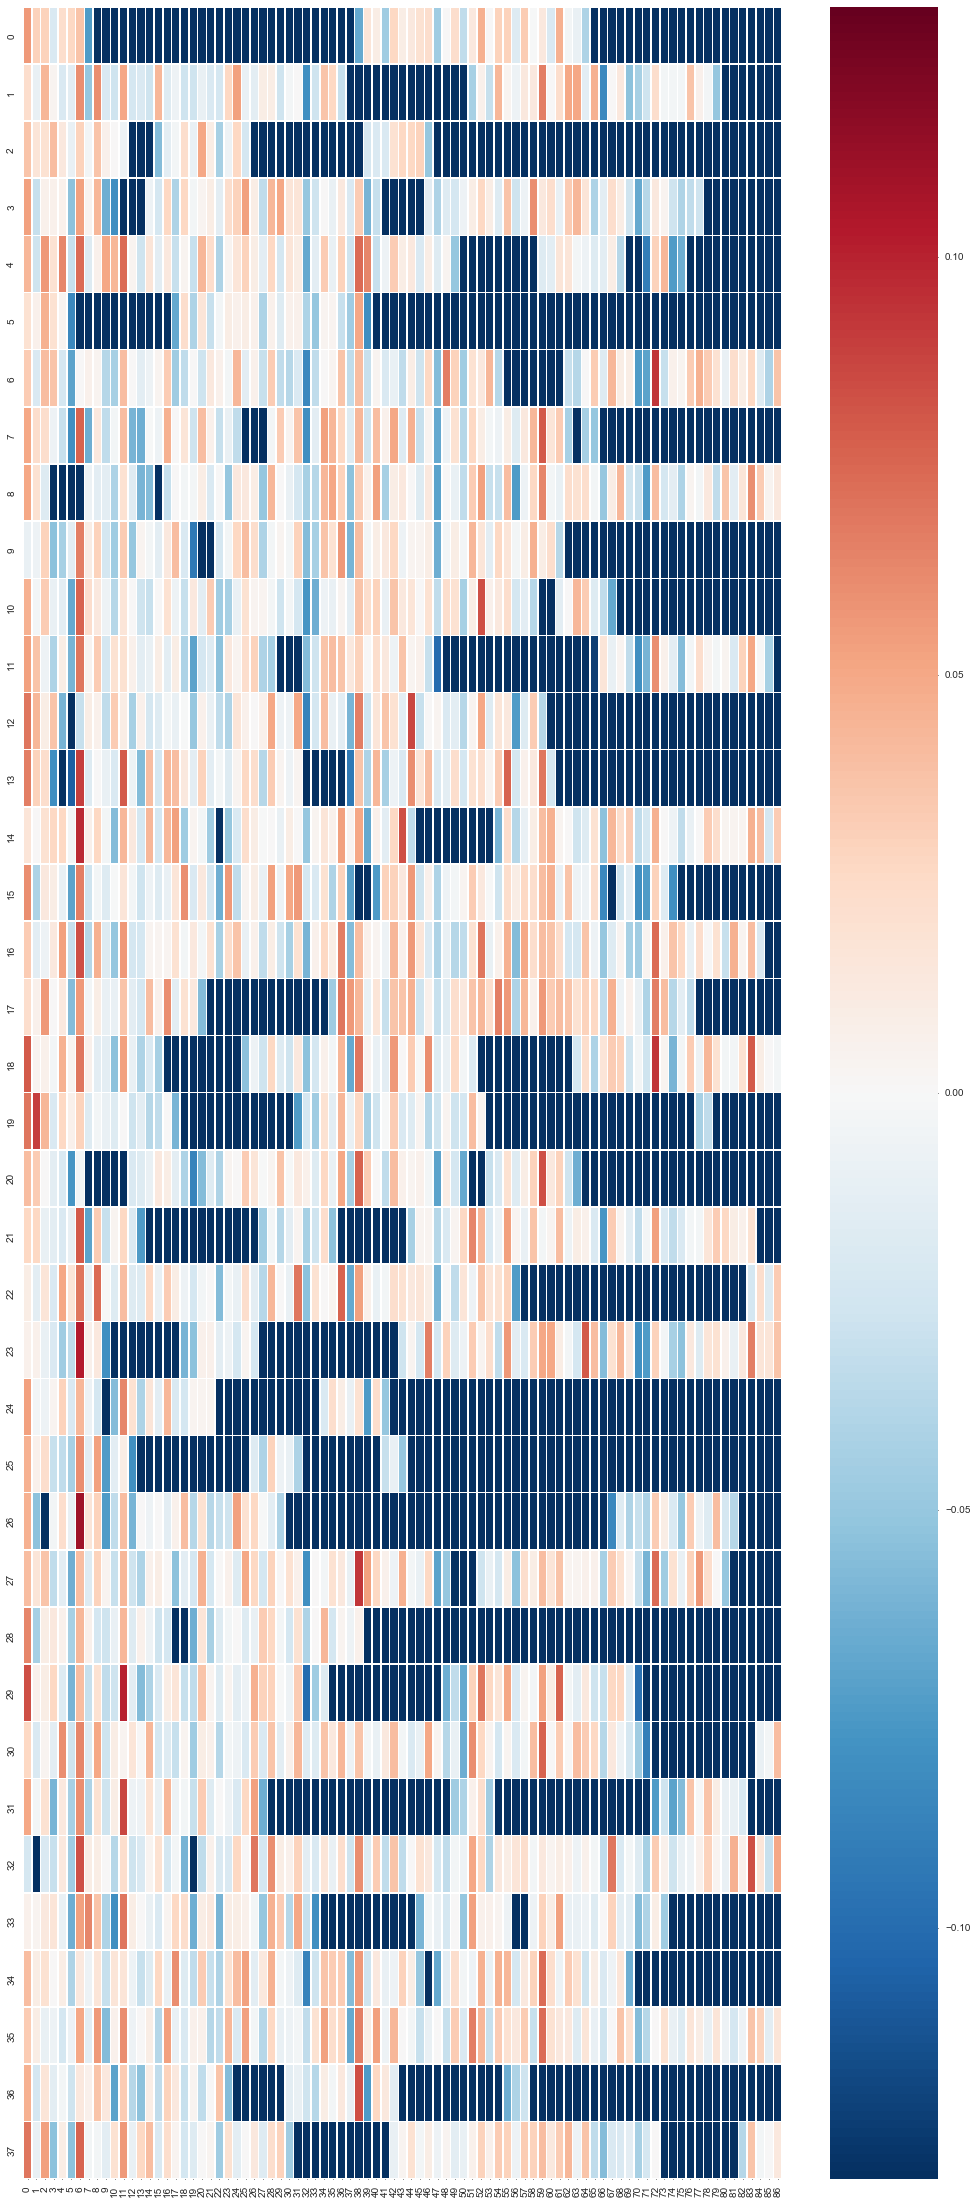

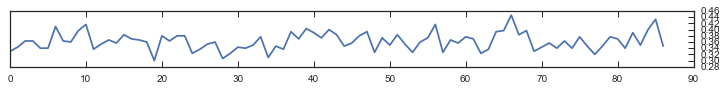

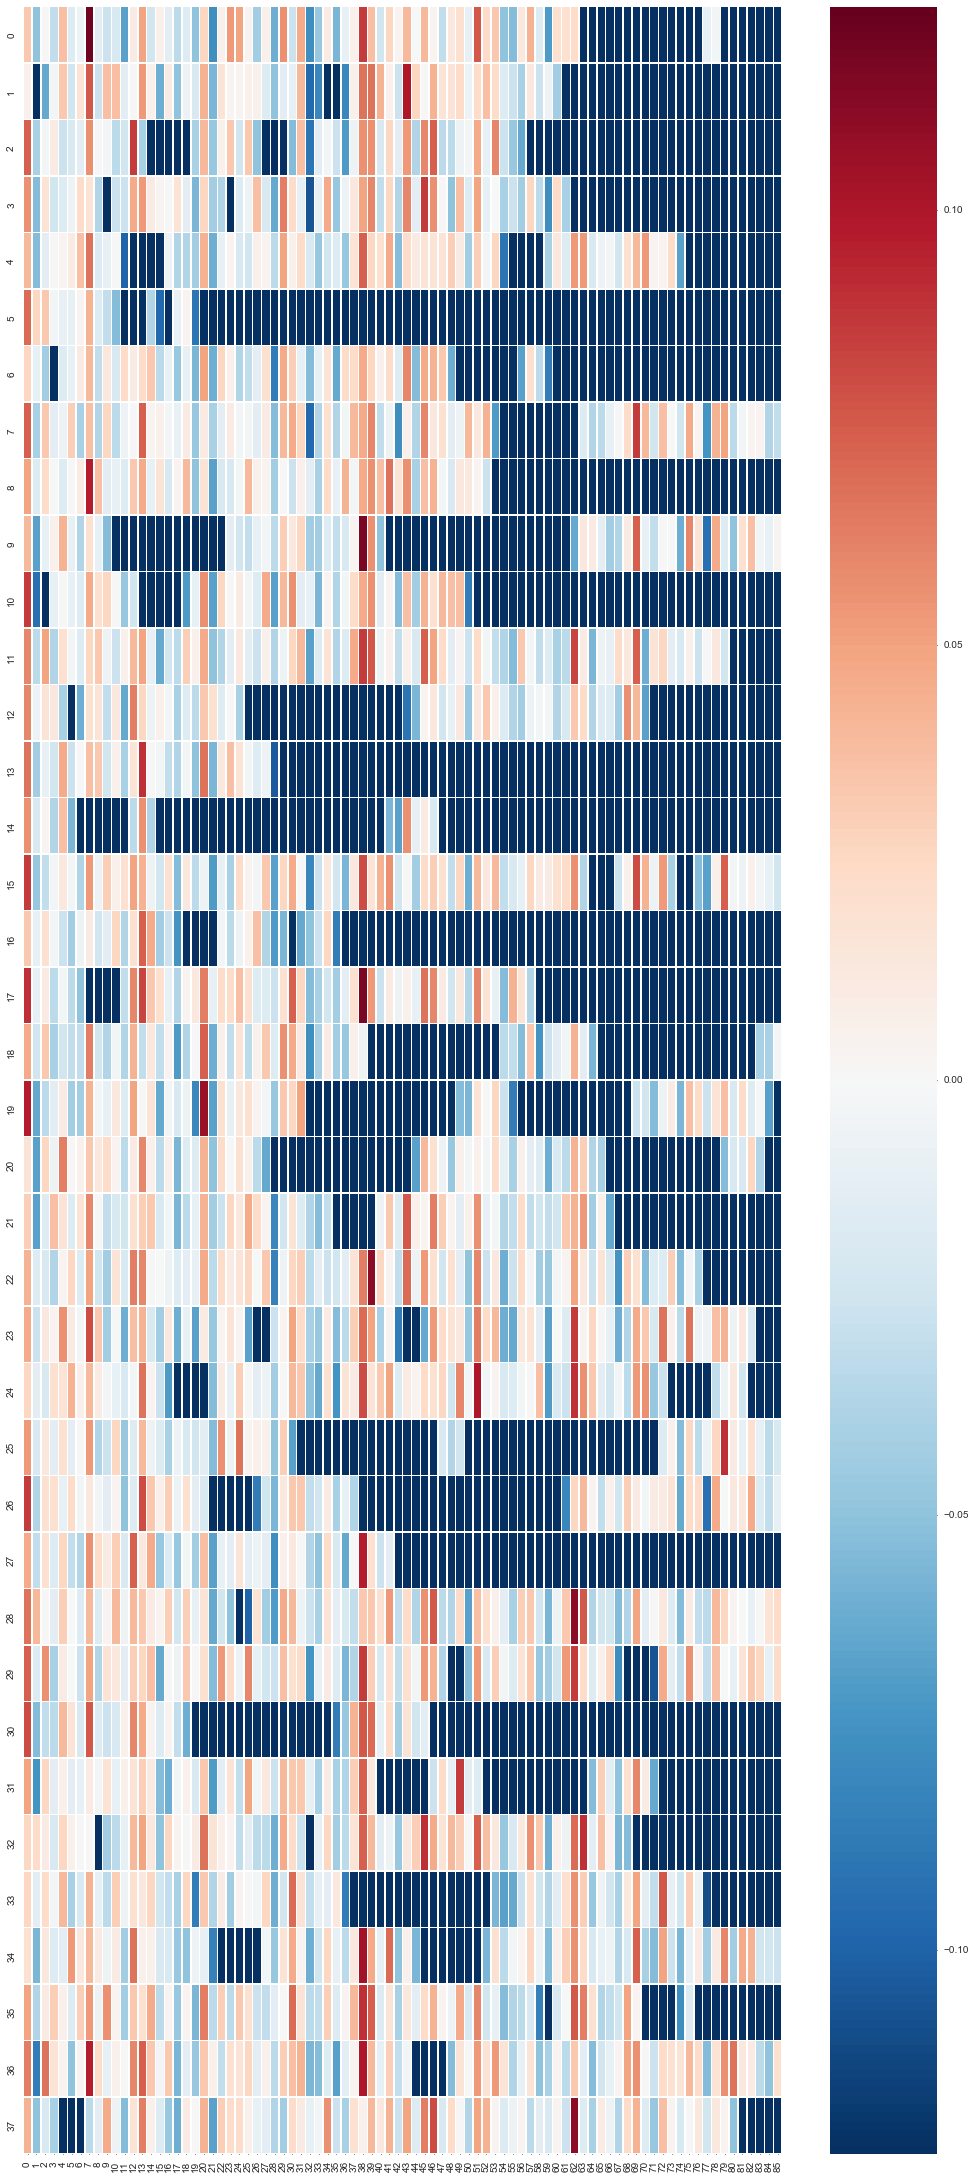

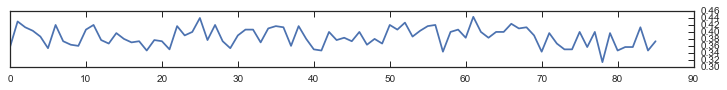

KeyboardInterrupt: 

In [197]:
fs_target = {}
fs_score_target = {}

for target in range(5):
    backwards_forwards_feature_selection(Xtz, Y[:, target], classifier_score)